### Import

In [1]:
import os
import re
import warnings
import collections
from random import shuffle
import shutil
import string
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
warnings.filterwarnings('ignore')

### Тональность текста

В блокноте text_classification.ipynb разобрали анализ тональности используя полносвязанную сеть сделать на тех же данных
1. tf-idf/count vectorizer + логистическую регрессию
2. Обучить вашу архитектуре сети возможно туже что и была на занятии проверить
•	взять предобученный эмбединг(к примеру word2vec) и загрузить в слой Embedding
•	взять слой Embedding без предобученных весов
Сравнить все подходы в том числе и полносвязанную сеть что лучше отработало


##### Data import

In [3]:
def load_dataset(train_test_flag, obj_count=-1):
    data_path = 'aclImdb'
    
    x_list = []
    target_list = []
    
    pos_list = []
    neg_list = []
    
    for file in os.listdir(os.path.join(data_path, train_test_flag, 'pos'))[:obj_count]:
        with open(os.path.join(data_path, train_test_flag, 'pos', file), 'r', encoding='utf=8') as f:
            pos_list.append(f.read())

    for file in os.listdir(os.path.join(data_path, train_test_flag, 'neg'))[:obj_count]:
        with open(os.path.join(data_path, train_test_flag, 'neg', file), 'r', encoding='utf=8') as f:
            neg_list.append(f.read())
            
    pos_list_len = len(pos_list)
    neg_list_len = len(neg_list)
    
    x_list = pos_list
    x_list.extend(neg_list)
    target_list = [1 for ind in range(pos_list_len)]
    target_list.extend([0 for ing in range(neg_list_len)])

    total_list = list(zip(x_list, target_list))
    shuffle(total_list)
    
    return [val[0] for val in total_list], [val[1] for val in total_list]

In [4]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()

train_df['X'], train_df['target'] = load_dataset(train_test_flag='train', obj_count=5000)
test_df['X'], test_df['target'] = load_dataset(train_test_flag='test', obj_count=5000)

In [5]:
train_df.head(3)

,X,target
0,"I first saw ""Breaking Glass"" in 1980, and thou...",1
1,"In 1972, after his wife left to go her own way...",0
2,Probable reasons why so many people on this si...,0


In [6]:
test_df.head(3)

,X,target
0,What does this movie have? Lots of gunfire and...,0
1,I am a Shakespeare lover since childhood. I am...,0
2,"I must first mention that as a group of mates,...",0


##### Data preprocessing

In [7]:
def removeApostrophe(review):
    phrase = re.sub(r"won't", "will not", review)
    phrase = re.sub(r"can\'t", "can not", review)
    phrase = re.sub(r"n\'t", " not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

def removeApostropheFixed(review):
    phrase = re.sub(r"won't", "willnot", review)
    phrase = re.sub(r"can\'t", "cannot", review)
    phrase = re.sub(r"\snot", "not", review)
    phrase = re.sub(r"n\'t", "not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

def removeSpecialChars(review):
     return re.sub('[^a-zA-Z]', ' ', review)
    
def doCleaningFixed(review):
    review = removeApostropheFixed(review)
    review = removeSpecialChars(review) 
    review = review.lower()  
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

def doTextCleaning(review):
    review = removeApostrophe(review)
    review = removeSpecialChars(review) 
    review = review.lower()  
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

In [8]:
train_df['preprocessed'] = train_df['X'].apply(doTextCleaning)
test_df['preprocessed'] = test_df['X'].apply(doCleaningFixed)

In [9]:
train_df.head(3)

,X,target,preprocessed
0,"I first saw ""Breaking Glass"" in 1980, and thou...",1,first saw breaking glass thought would one mov...
1,"In 1972, after his wife left to go her own way...",0,wife left go way elvis presley began dating li...
2,Probable reasons why so many people on this si...,0,probable reason many people site enjoyed br br...


##### TF-IDF

In [10]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vectorizer.fit(train_df['preprocessed'])

train_tfidf = tfidf_vectorizer.transform(train_df['preprocessed'])
test_tfidf = tfidf_vectorizer.transform(test_df['preprocessed'])

##### Logistic Regression

In [11]:
def train_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_test)
    
    return metrics.accuracy_score(predictions, y_test)


accuracy = train_model(classifier=linear_model.LogisticRegression(),
                       X_train=train_tfidf,
                       y_train=train_df['target'],
                       X_test=test_tfidf,
                       y_test=test_df['target'])
accuracy

0.8663

##### Deep Learning model

Импорт данных.

In [12]:
dataset_dir = 'aclImdb'

train_dir = os.path.join(dataset_dir, 'train')

batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_train_ds))

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

embedding_dim = 16

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Объявление модели.

In [13]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim,),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(145),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 145)               2465      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 146       
Total params: 162,627
Trainable params: 162,627
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Обучение модели.

In [15]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4688 - binary_accuracy: 0.7649 - val_loss: 0.3285 - val_binary_accuracy: 0.8568
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2584 - binary_accuracy: 0.8989 - val_loss: 0.3066 - val_binary_accuracy: 0.8718
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2030 - binary_accuracy: 0.9230 - val_loss: 0.3158 - val_binary_accuracy: 0.8726
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1641 - binary_accuracy: 0.9386 - val_loss: 0.3437 - val_binary_accuracy: 0.8690
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1378 - binary_accuracy: 0.9505 - val_loss: 0.3869 - val_binary_accuracy: 0.8712
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1133 - binary_accuracy: 0.9610 - val_loss: 0.4359 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 2s 3ms/s

In [16]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 11s 14ms/step - loss: 0.8435 - binary_accuracy: 0.8357


Копирую текущие веса слоя эмбеддинга модели и сам слой полностью.

In [17]:
model_embedding_layer = model.layers[0]
model_embedding_weights = model.layers[0].weights

model_embedding_layer, model_embedding_weights[0].shape

(<tensorflow.python.keras.layers.embeddings.Embedding at 0x217da341148>,
 TensorShape([10001, 16]))

Обучаю word2vec.

In [18]:
modelW2V = Word2Vec(sentences=train_df['preprocessed'],
                    size=16, 
                    window=5,
                    min_count=2,
                    sg = 1,
                    hs = 0,
                    negative = 10,
                    workers= 32,
                    seed = 34)

%time modelW2V.train(sentences=train_df['preprocessed'], total_examples=modelW2V.corpus_count, epochs=20)

Wall time: 1min 1s


(27884711, 162606020)

In [19]:
words = []

def words_counter(document):
    for word in document.split():
        words.append(word)

def get_vec_word(word):
    return modelW2V.wv[word] if word in modelW2V else np.zeros(16)

[words_counter(document) for document in train_df['preprocessed']];

In [20]:
f_words = Counter(words)
f_words = list(dict(f_words).items())

f_words.sort(key=lambda x: x[1], reverse=True)

In [21]:
f_words = [word[0] for word in f_words[:10001]]

In [22]:
w2v_embeddings = [get_vec_word(word) for word in f_words]

In [23]:
np.array(w2v_embeddings).shape

(10001, 16)

Заменяю веса слоя эмбеддинга на обученные через word2vec эмбеддинги слов.

In [24]:
model.layers[0].set_weights([np.array(w2v_embeddings)])

Замеряю качество после такой замены.

In [25]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 0s 533us/step - loss: 0.6909 - binary_accuracy: 0.5073


In [26]:
model.layers[0].trainable=False

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3729 - binary_accuracy: 0.8385 - val_loss: 0.3016 - val_binary_accuracy: 0.8754
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2114 - binary_accuracy: 0.9178 - val_loss: 0.3183 - val_binary_accuracy: 0.8732
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1688 - binary_accuracy: 0.9348 - val_loss: 0.3690 - val_binary_accuracy: 0.8700
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1424 - binary_accuracy: 0.9463 - val_loss: 0.4240 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1241 - binary_accuracy: 0.9547 - val_loss: 0.4637 - val_binary_accuracy: 0.8632
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1123 - binary_accuracy: 0.9567 - val_loss: 0.5233 - val_binary_accuracy: 0.8572
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [28]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 0s 527us/step - loss: 0.9649 - binary_accuracy: 0.8090


In [41]:
model.layers[0].trainable=True

In [42]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0737 - binary_accuracy: 0.9716 - val_loss: 0.7595 - val_binary_accuracy: 0.8484
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0724 - binary_accuracy: 0.9728 - val_loss: 0.7432 - val_binary_accuracy: 0.8500
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0717 - binary_accuracy: 0.9727 - val_loss: 0.7416 - val_binary_accuracy: 0.8534
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0560 - binary_accuracy: 0.9786 - val_loss: 0.8420 - val_binary_accuracy: 0.8510
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0556 - binary_accuracy: 0.9783 - val_loss: 0.8814 - val_binary_accuracy: 0.8494
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0609 - binary_accuracy: 0.9750 - val_loss: 0.8704 - val_binary_accuracy: 0.8516
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [43]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 0s 505us/step - loss: 1.2836 - binary_accuracy: 0.8242


По факту TF-IDF + логистическая регрессия дают лучший результат чем данная архитектура нейросети. А добавление предобученных эмбеддингов не улучшает результаты нейросети.

### Классификация текста

#### Import

In [29]:
labels = pd.read_pickle('labels.pickle')

data_files = ['bow_stemmed_count.pickle', 'bow_stammed_tfidf.pickle', 
              'bow_lemmatized_count.pickle', 'bow_lemmatized_tfidf.pickle']

#### Задание 1.

Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


In [30]:
def process(matrix, true_values, model):
    split_index = 31962
    
    train_X = matrix[:split_index]
    test_X = matrix[split_index:]
    
    train_y = true_values[:split_index]
    test_y = [(val if val in [0, 1] else 1) for val in true_values[split_index:]]
    
    model.fit(train_X, train_y)
    preds = model.predict_proba(test_X)
    preds = [(1 if val[0] >= 0.3 else 0) for val in preds]
    
    d = pd.DataFrame({'true': test_y, 'pred': preds})
    
    f1 = f1_score(test_y, preds)
    return round(f1, 5)

In [31]:
df = pd.read_pickle('bow_stemmed_count.pickle')
print(f'stemmed, count vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

df = pd.read_pickle('bow_lemmatized_count.pickle')
print(f'stemmed, count vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

stemmed, count vectorizer, f1: 0.9871
stemmed, count vectorizer, f1: 0.98788


#### Задание 2.

Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


In [32]:
df = pd.read_pickle('bow_stemmed_tfidf.pickle')
print(f'stemmed, tfidf vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

df = pd.read_pickle('bow_lemmatized_tfidf.pickle')
print(f'stemmed, tfidf vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

stemmed, tfidf vectorizer, f1: 0.99016
stemmed, tfidf vectorizer, f1: 0.99105


#### Задание 3.

Выведите результаты f1-score всех моделей, сделайте вывод.

In [33]:
df = pd.read_pickle('bow_stemmed_count.pickle')
print(f'stemmed, count vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

df = pd.read_pickle('bow_lemmatized_count.pickle')
print(f'stemmed, count vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

df = pd.read_pickle('bow_stemmed_tfidf.pickle')
print(f'stemmed, tfidf vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

df = pd.read_pickle('bow_lemmatized_tfidf.pickle')
print(f'stemmed, tfidf vectorizer, f1: {process(df, labels, linear_model.LogisticRegression())}')

stemmed, count vectorizer, f1: 0.9871
stemmed, count vectorizer, f1: 0.98788
stemmed, tfidf vectorizer, f1: 0.99016
stemmed, tfidf vectorizer, f1: 0.99105


Выводы: ожидаемо лемматизация работает лучше чем стемминг, а tfidf векторизация - лучше, чем count векторизация. Ну и лучший вариант ожидаемо - стемминг+tfidf векторизация.

#### Задание 4.

Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова


In [34]:
df = pd.read_pickle('preprocessed_tweets.pickle')

In [35]:
df.head(3)

,id,label,tweet,tweet_source,tweet_,tweet_token,tweet_token_,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,when father is dysfunctional and is so selfish...,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,thanks for lyft credit cannot use cause they d...,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee..."
2,3,0.0,bihday your majesty,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]"


In [36]:
def words_cloud_draw(labels=[0,1], stop_words=[]):
    words = []
    for tweet_words in df.loc[df['label'].isin(labels), 'tweet_lemmatized']: 
        words.extend(tweet_words)

    wordfreq = collections.Counter(words)

    wordcloud = WordCloud(
     background_color=('white' if labels == [0] else ('black' if labels == [1] else 'grey')),
     max_words=200,
     stopwords=stop_words).generate_from_frequencies(wordfreq)
    plt.figure(figsize=(10,9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Визуализация со стоп-словами.

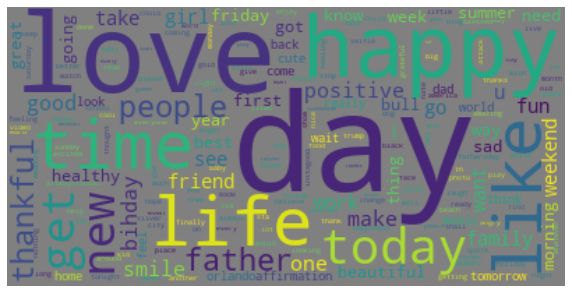

In [37]:
words_cloud_draw(labels=[0,1], stop_words=[])

Визуализация без стоп-слов.

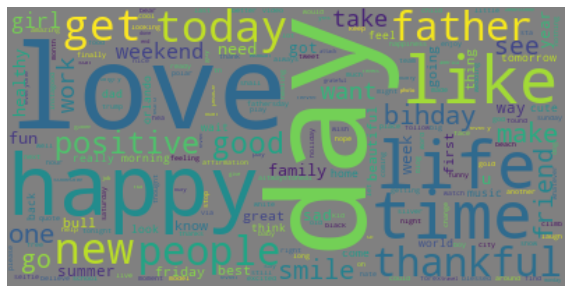

In [38]:
words_cloud_draw(labels=[0,1], stop_words=stopwords)

#### Задание 5.

Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

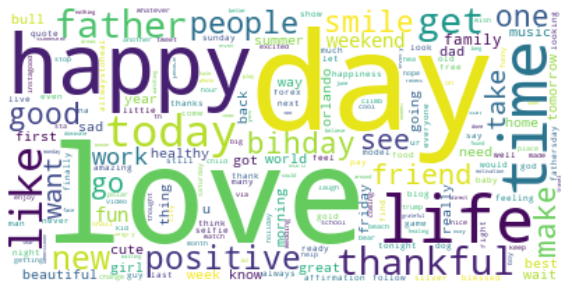

In [39]:
words_cloud_draw(labels=[0], stop_words=stopwords)

#### Задание 6.

Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

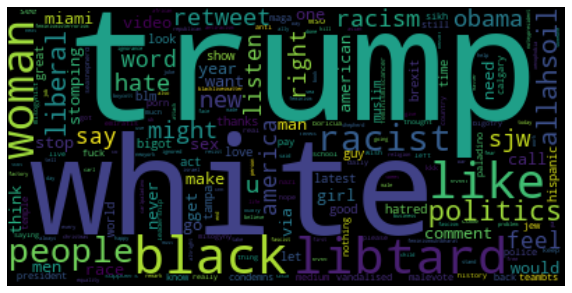

In [40]:
words_cloud_draw(labels=[1], stop_words=[])